In [ ]:
## This is a series of examples demonstrating the use of the icanswim/qchem repo 
## for quantum mechanic geometric machine learning utilizing pytorch, pyg and rdkit.
## This is a demonstration of the use of the icanswim/cosmosis repo for 
## data science and machine learning projects.

In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../')

import warnings
warnings.filterwarnings('ignore', category=UserWarning,
                            message='TypedStorage is deprecated')

import copy
import numpy as np

from cosmosis.model import FFNet
from cosmosis.dataset import SKDS, Pad1d, Flatten, Reshape, ExpandN
from cosmosis.dataset import SqueezeN, Index, EmbedLookup, AsSparse, AsTensor

from learning import Learn, Selector
from dataset import QM7, QM7b, QM7X, ANI1x, QM9, PGDS
from model import GraphNet, PygModel, EncoderLoss, GraphNetVariationalEncoder 

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss, NLLLoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T


In [2]:
qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']

ds_params = {'train_params': {'input_dict': {'model_input': {'x': [
                                                                   'atomic_number',
                                                                   'aromatic',
                                                                   'degree',
                                                                   'mulliken',
                                                                  ],
                                                             'idx': ['idx'],
                                                             'edge_index': ['edge_indices'],
                                                             #'edge_attr': ['edge_attr'],
                                                             #'coulomb': ['coulomb'],
                                                             #'distance': ['distance'],
                                                             #'embed': ['hybridization','chirality'],
                                                             #'adjacency': ['adjacency'],
                                                             #'mulliken': ['mulliken'],
                                                            },
                                             'criterion_input': {'y': ['U0']}},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid)],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral)],
                                             'atomic_number': [ExpandN(1),AsTensor()],
                                             'aromatic': [ExpandN(1), AsTensor()],
                                             'degree': [ExpandN(1), AsTensor()],
                                             'edge_indices': [AsTensor()],
                                             'mulliken': [ExpandN(1), AsTensor()],
                                             'coulomb': [],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [AsTensor()],
                                             'U0': [AsTensor()],
                                            },
                              #'filter_on': ('n_atoms','<','10'), 
                              'n': 10000, #non-random subset for testing,
                              'use_pickle': 'qm9_10k_3_conf', #use pickle if exists otherwise create
                              'n_conformers': 3,
                              'dict2data': True}}

qm9 = QM9(**ds_params['train_params'])
qm9[1]

creating QM9 dataset...
molecules scanned:  1
molecules created:  1
molecules scanned:  10001
molecules created:  9502
total molecules scanned:  10504
total uncharacterized molecules removed:  285
total molecules removed for insuffient rdmol conformations:  504
total molecules created:  9715
CDataset created...


Data(x=[5, 4], edge_index=[2, 8], y=[1], idx=1)

In [4]:
qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']

ds_params = {'train_params': {'input_dict': {'model_input': {'X': [
                                                                   'atomic_number',
                                                                   'aromatic',
                                                                   'degree',
                                                                   'mulliken',
                                                                   'coulomb',
                                                                  ],
                                                             'idx': ['idx'],
                                                             #'edge_index': ['edge_indices'],
                                                             #'edge_attr': ['edge_attr'],
                                                             #'coulomb': ['coulomb'],
                                                             #'distance': ['distance'],
                                                             'embed': ['hybridization','chirality'],
                                                             #'adjacency': ['adjacency'],
                                                             #'mulliken': ['mulliken'],
                                                            },
                                             'criterion_input': {'y': ['U0']}},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid)],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral)],
                                             'atomic_number': [Pad1d(29)],
                                             'aromatic': [Pad1d(29)],
                                             'degree': [Pad1d(29)],
                                             'edge_indices': [],
                                             'mulliken': [Pad1d(29)],
                                             'coulomb': [Flatten(),Pad1d(29*29)],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [],
                                             'U0': [],
                                            },
                              #'filter_on': ('n_atoms','<','10'), 
                              'n': 100, #non-random subset for testing,
                              #'use_pickle': 'qm9_full_ds_0_conf', #use pickle if exists otherwise create
                              'n_conformers': 0,
                              'dict2data': False}}

qm9 = QM9(**ds_params['train_params'])
qm9[1]

creating QM9 dataset...
molecules scanned:  1
molecules created:  1
total molecules scanned:  100
total uncharacterized molecules removed:  3
total molecules removed for insuffient rdmol conformations:  0
total molecules created:  97
CDataset created...


{'model_input': {'X': array([ 6.       ,  1.       ,  1.       ,  1.       ,  1.       ,
          0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
          0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
          0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
          0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
          0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
          0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
          0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
          0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
          0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
          0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
          0.       ,  0.       ,  0.       ,  4.       ,  1.       ,
          1.       ,  1.       ,  1.       ,  0.       ,  0.       ,
          0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
          0.  

In [5]:
#example pyg dataset wrapper PGDS
ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': None}}}

pgds = PGDS(**ds_params['train_params'])
pgds[0]

creating pytorch geometric QM9 dataset...
CDataset created...


Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])

In [6]:
#example creating preprocessed cosmosis/qchem QM9 dataset augmented with
#rdkit mol data (1.7 GB, 133,885 molecules)
#the preprocessing can be greedy or thrifty to optimize speed or memory

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']

ds_params = {'train_params': {'input_dict': {'model_input': {'x': [
                                                                   'atomic_number',
                                                                   'aromatic',
                                                                   'degree',
                                                                   'mulliken',
                                                                  ],
                                                             'idx': ['idx'],
                                                             'edge_index': ['edge_indices'],
                                                             'edge_attr': ['edge_attr'],
                                                             'coulomb': ['coulomb'],
                                                             'distance': ['distance'],
                                                             'embed': ['hybridization','chirality'],
                                                             'adjacency': ['adjacency'],
                                                             #'mulliken': ['mulliken'],
                                                            },
                                             'criterion_input': {'y': ['U0']}},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid)],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral)],
                                             'atomic_number': [ExpandN(1),AsTensor()],
                                             'aromatic': [ExpandN(1), AsTensor()],
                                             'degree': [ExpandN(1), AsTensor()],
                                             'edge_indices': [AsTensor()],
                                             'mulliken': [ExpandN(1), AsTensor()],
                                             'coulomb': [],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [AsTensor()],
                                             'U0': [AsTensor()],
                                            },
                              #'filter_on': ('n_atoms','<','10'), 
                              'n': 100, #non-random subset for testing,
                              #'use_pickle': 'qm9_full_ds_0_conf', #use pickle if exists otherwise create
                              'n_conformers': 0,
                              'dict2data': True}}

qm9 = QM9(**ds_params['train_params'])

ds_idx = np.arange(100)
selector = Selector(train_idx=ds_idx)
selector('train')
loader = DataLoader(qm9, batch_size=2, sampler=selector)
batch = next(iter(loader))
print('batch: ', batch)
print('batch.ptr: ', batch.ptr)
print('batch.idx: ', batch.idx)
print('batch.x: ', batch.x)
print('pgds[1]: ', qm9[1])
print('pgds[1].x: ', qm9[1].x)
print('pgds[1].y: ', qm9[1].y)
print('pgds[1].idx: ', qm9[1].idx)
print('pgds[1].edge_index: ', qm9[1].edge_index)
print('pgds[1].edge_attr: ', qm9[1].edge_attr)

creating QM9 dataset...
molecules scanned:  1
molecules created:  1
total molecules scanned:  100
total uncharacterized molecules removed:  3
total molecules removed for insuffient rdmol conformations:  0
total molecules created:  97
CDataset created...
batch:  DataBatch(x=[23, 4], edge_index=[2, 44], edge_attr=[2], y=[2], idx=[2], coulomb=[2], distance=[2], embed=[2], adjacency=[2], batch=[23], ptr=[3])
batch.ptr:  tensor([ 0, 11, 23])
batch.idx:  tensor([45, 73])
batch.x:  tensor([[ 6.0000,  0.0000,  4.0000, -0.3055],
        [ 7.0000,  0.0000,  3.0000, -0.0524],
        [ 6.0000,  0.0000,  4.0000, -0.2121],
        [ 6.0000,  0.0000,  4.0000, -0.2121],
        [ 1.0000,  0.0000,  1.0000,  0.0933],
        [ 1.0000,  0.0000,  1.0000,  0.1225],
        [ 1.0000,  0.0000,  1.0000,  0.1225],
        [ 1.0000,  0.0000,  1.0000,  0.1161],
        [ 1.0000,  0.0000,  1.0000,  0.1058],
        [ 1.0000,  0.0000,  1.0000,  0.1058],
        [ 1.0000,  0.0000,  1.0000,  0.1161],
        [ 6.00

creating QM9 dataset...
molecules scanned:  1
molecules created:  1
total molecules scanned:  10000
total uncharacterized molecules removed:  273
total molecules removed for insuffient rdmol conformations:  0
total molecules created:  9727
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:03.131233
epoch: 0, lr: 0.01
train loss: 116.07726305835652, val loss: 21.425166910344903
learning time: 0:00:13.576223
epoch: 6, lr: 0.01
train loss: 13.103808510978267, val loss: 11.956710642034357
test loss: 9.248049475929953
learning time: 0:00:19.132504


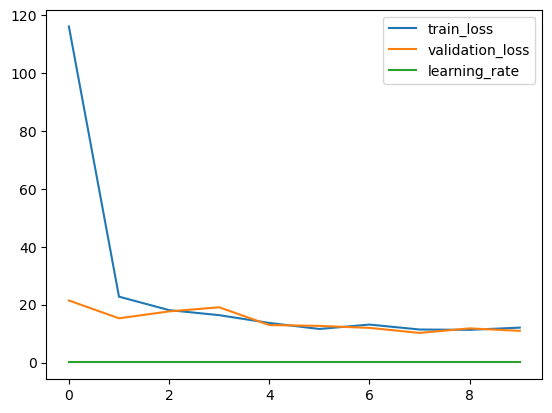

In [7]:
#example using cosmosis/qchem preprocessed QM9 dataset and custom cosmosis/qchem model

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']
#cosmosis uses 'X' and 'target' while 'pyg' uses 'x' and 'y'
ds_params = {'train_params': {'input_dict': {'model_input': {'X': [
                                                                   'atomic_number',
                                                                   'aromatic',
                                                                   'degree',
                                                                   'mulliken',
                                                                   'coulomb',
                                                                  ],
                                                             'idx': ['idx'],
                                                             #'edge_index': ['edge_indices'],
                                                             #'edge_attr': ['edge_attr'],
                                                             'coulomb': ['coulomb'],
                                                             #'distance': ['distance'],
                                                             'embed': ['hybridization','chirality'],
                                                             #'adjacency': ['adjacency'],
                                                             #'mulliken': ['mulliken'],
                                                            },
                                             'criterion_input': {'target': ['U0']}},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid)],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral)],
                                             'atomic_number': [Pad1d(29)],
                                             'aromatic': [Pad1d(29)],
                                             'degree': [Pad1d(29)],
                                             'edge_indices': [],
                                             'mulliken': [Pad1d(29)],
                                             'coulomb': [Flatten(),Pad1d(29*29)],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [],
                                             'U0': [],
                                            },
                              #'filter_on': ('n_atoms','<','10'), 
                              'n': 10000, #non-random subset for testing,
                              #'use_pickle': 'qm9_full_ds_0_conf', #use pickle if exists otherwise create
                              'n_conformers': 0,
                              'dict2data': False}}

model_params = {'in_channels': 29+29+29+29+29*29+29*8+29*8, #1421=957+464
                'hidden': 4096, 
                'out_channels': 1, 
                'model_name': 'funnel',
                'embed_params': [('hybridization',9,8,0,True),('chirality',4,8,0,True)],
               }      

metrics_params = {'report_interval': 1,
                  'log_plot': False}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 #'subset': .1, #create random subset
                }

sched_params = {'factor': .5,
                'patience': 3,
                'cooldown': 1,
                'min_lr': .005}

opt_params = {'lr': 0.01}


l = Learn([QM9], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          squeeze_y_pred=False, batch_size=128, epochs=10, save_model=True)

In [ ]:
#example creating preprocessed cosmosis/qchem QM9 dataset augmented with
#rdkit mol data (6.5 GB, 114,711 molecules)
#the preprocessing can be greedy or thrifty to optimize speed or memory

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']
ds_params = {'train_params': {'input_dict': {'model_input': {'X': [
                                                                   'atomic_number',
                                                                   'coulomb',
                                                                   'aromatic',
                                                                   'degree',
                                                                  ],
                                                             #'edge_idx': ['edge_indices'],
                                                             #'edge_attr': ['edge_attr'],
                                                             #'coulomb': ['coulomb'],
                                                             'distance': ['distance'],
                                                             'embed': ['hybridization','chirality'],
                                                             'adjacency': ['adjacency'],
                                                             'mulliken': ['mulliken'],
                                                            },
                                             'criterion_input': {'target': ['U0']}},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid)],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral)],
                                             'atomic_number': [Pad1d(29)],
                                             'aromatic': [Pad1d(29)],
                                             'degree': [Pad1d(29)],
                                             'mulliken': [Pad1d(29)],
                                             'coulomb': [Reshape((-1)), Pad1d(29*29)],
                                             'distance': [Reshape((-1)), Pad1d(29*29)],
                                             'adjacency': [Reshape((-1)), Pad1d(29*29)],
                                            },
                              #'filter_on': ('n_atoms','<','10'), 
                              'n': 100, #non-random subset for testing,
                              #'use_pickle': 'qm9_full_ds_10_conf', #use pickle if exists otherwise create
                              'n_conformers': 10}}

qm9 = QM9(**ds_params['train_params'])
qm9[1]

In [ ]:
#example exploring cosmosis/qchem QM9 dataset

l, s, li, si = 0, 9999, 0, 0
for i in qm9.ds_idx:
    d = qm9[i]['model_input']['X'].shape[0]
    if d > l:
        l = d
        li = i
    if d < s:
        s = d
        si = i
print('longest molecule index: ', li, ' length: ', l)
print('shortest molecule index: ', si, ' length: ', s)
qm9[si]

In [ ]:
#example exploring cosmosis/qchem PyG dataset wrapper with Data object output

import copy
class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

ds_params = {'train_params': {'dataset': 'QM9',
                              'pg_params': {'root': './data/',
                                            'transform': IndexY(1)}}}

pgds = PGDS(**ds_params['train_params'])
ds_idx = np.arange(1000)
selector = Selector(train_idx=ds_idx)
selector('train')
loader = DataLoader(pgds, batch_size=2, sampler=selector)
batch = next(iter(loader))
print('batch: ', batch)
print('batch.ptr: ', batch.ptr)
print('batch.idx: ', batch.idx)
print('batch.x: ', batch.x)
print('pgds[1]: ', pgds[1])
print('pgds[1].x: ', pgds[1].x)
print('pgds[1].y: ', pgds[1].y)
print('pgds[1].idx: ', pgds[1].idx)
print('pgds[1].edge_index: ', pgds[1].edge_index)
print('pgds[1].edge_attr: ', pgds[1].edge_attr)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/miniconda3/envs/qchem/lib/python3.12/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:27.104478
epoch: 0, lr: 0.01
train loss: 1.6490617481266416, val loss: 1.375218573369478
learning time: 0:00:53.301157
epoch: 1, lr: 0.01
train loss: 1.3467077350750023, val loss: 1.2764148704315488
learning time: 0:01:19.941224
epoch: 2, lr: 0.01
train loss: 1.2879764935215647, val loss: 1.2211307640138425
learning time: 0:01:45.815888
epoch: 3, lr: 0.01
train loss: 1.2355497240686284, val loss: 1.2048565400274176
learning time: 0:02:11.545869
epoch: 4, lr: 0.01
train loss: 1.1854627872047638, val loss: 1.1298644942672629
learning time: 0:02:37.456985
epoch: 5, lr: 0.01
train loss: 1.1300591110181408, val loss: 1.1116161213109368
learning time: 0:03:03.839351
epoch: 6, 

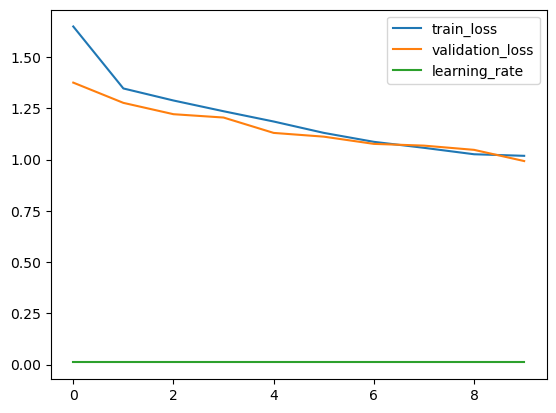

In [2]:
#example cosmosis/qchem PyG dataset wrapper with Data object output with
#custom transforms and sklearn metrics and custom PyG model

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        #Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

model_params = {'in_channels': 11, 
                'hidden': 128, 
                'out_channels': 1,
                'depth': 1,
                'convolution': 'NetConv',
                'pool': 'MeanAggregation',
                'dropout': .1,
                'softmax': None,
                'activation': 'relu',
                'edge_features': 4,
               }

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': T.Compose([IndexY(0), 
                                                                   ])}}}

metrics_params = {'report_interval': 10,
                  'log_plot': False}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=True, batch_size=256, epochs=10)

In [2]:
qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']

ds_params = {'train_params': {'input_dict': {'model_input': {'x': [
                                                                   'atomic_number',
                                                                   'aromatic',
                                                                   'degree',
                                                                   'mulliken',
                                                                  ],
                                                             'idx': ['idx'],
                                                             'edge_index': ['edge_indices'],
                                                             #'edge_attr': ['edge_attr'],
                                                             #'coulomb': ['coulomb'],
                                                             #'distance': ['distance'],
                                                             #'embed': ['hybridization','chirality'],
                                                             #'adjacency': ['adjacency'],
                                                             #'mulliken': ['mulliken'],
                                                            },
                                             'criterion_input': {'y': ['U0']}},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid)],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral)],
                                             'atomic_number': [ExpandN(1),AsTensor()],
                                             'aromatic': [ExpandN(1), AsTensor()],
                                             'degree': [ExpandN(1), AsTensor()],
                                             'edge_indices': [AsTensor()],
                                             'mulliken': [ExpandN(1), AsTensor()],
                                             'coulomb': [],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [AsTensor()],
                                             'U0': [AsTensor()],
                                            },
                              #'filter_on': ('n_atoms','<','10'), 
                              #'n': 10000, #non-random subset for testing,
                              'use_pickle': 'qm9_10k_3_conf', #use pickle if exists otherwise create
                              'n_conformers': 3,
                              'dict2data': True}}


model_params = {'in_channels': 4, 
                'hidden': 512, 
                'out_channels': 1,
                'depth': 2,
                'convolution': 'SAGEConv',
                'pool': 'MeanAggregation',
                'dropout': .1,
                'softmax': None,
                'activation': 'relu',
               }

metrics_params = {'report_interval': 30,
                  'log_plot': True}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2,
                'min_lr': .0025}


l = Learn([QM9], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=True, batch_size=256, epochs=50)

loading QM9 datadic from a pickled copy...
CDataset created...
FFNet model loaded...
CModel loaded...
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/miniconda3/envs/qchem/lib/python3.12/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:02.389523
epoch: 0, lr: 0.01
train loss: 115452.27674278847, val loss: 96303.3828125


ERROR: Unexpected segmentation fault encountered in worker.
 

RuntimeError: DataLoader worker (pid(s) 2988939) exited unexpectedly

In [ ]:
#example graph variational autoencoder without adversarial regulation and GCNConv encoder

model_params = {'in_channels': 11, 
                'hidden': 32, 
                'out_channels': 32,
                'depth': 2,
                'softmax': None,
                'pool': None,
                'convolution': 'GCNConv'}

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': None}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True,
                  'sk_metric_name': 'roc_auc_score',
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'adversarial': False,
               'disc_params': {'in_channels': 32, 'hidden': 64, 
                                'out_channels': 32, 'softmax': None}}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15),
                 'subset': False}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


l = Learn([PGDS], GraphNetVariationalEncoder, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=EncoderLoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=False, batch_size=128, epochs=10)

In [ ]:
#example graph variational autoencoder with adversarial regulation and GCNConv encoder

model_params = {'in_channels': 11, 
                'hidden': 32, 
                'out_channels': 32,
                'depth': 2,
                'softmax': None,
                'pool': None,
                'convolution': 'GCNConv'}

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': None}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True,
                  'sk_metric_name': 'roc_auc_score',
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'adversarial': True,
               'disc_params': {'in_channels': 32, 'hidden': 64, 
                                'out_channels': 32, 'softmax': None}}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15),
                 'subset': False}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


l = Learn([PGDS], GraphNetVariationalEncoder, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=EncoderLoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=False, batch_size=128, epochs=10)

In [ ]:
#example cosmosis/qchem PyG dataset wrapper with Data object output with
#custom transforms and sklearn metrics and custom PyG model

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

model_params = {'in_channels': 11, 
                'hidden': 256, 
                'out_channels': 1,
                'depth': 2,
                'convolution': 'SAGEConv',
                'pool': 'MeanAggregation',
                'dropout': .1,
                'softmax': None,
                'activation': 'relu',
               }

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': T.Compose([IndexY(0), 
                                                                   ])}}}

metrics_params = {'report_interval': 10,
                  'log_plot': False}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=True, batch_size=256, epochs=2)

In [ ]:
#example cosmosis/qchem PyG dataset wrapper with Data object output with
#custom transforms and sklearn metrics and PyG model

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

model_params = {'model_name': 'GraphSAGE',
                'softmax': None,
                'pool': 'MeanAggregation',
                'ffnet': True,
                'in_channels': 256, #ffnet params
                'hidden': 256, 
                'out_channels': 1, 
                'pyg_params': {'in_channels': 11, #GraphSAGE params
                               'hidden_channels': 256,
                               'num_layers': 2,
                               'out_channels': 256,
                               'dropout': .1,
                               'norm': 'BatchNorm'}}

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': T.Compose([IndexY(0)])}}}

metrics_params = {'report_interval': 10,
                  'log_plot': False}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


l = Learn([PGDS], PygModel, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=True, batch_size=256, epochs=2)

In [ ]:
#example cosmosis/qchem PyG dataset wrapper with custum transform with
#dictionary output and custom cosmosis model

model_params = {'in_channels': 319, 
                'hidden': 512, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {'y': [Index(0)],
                                             'x': [Pad((29,11)), Flatten()]},
                              'input_dict': {'model_input': {'X': ['x']},
                                             'criterion_input': {'target': ['y']}},
                              'pg_params': {'root': './data/'}}}

metrics_params = {'report_interval': 10,
                  'log_plot': False}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


l = Learn([PGDS], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=20)

In [ ]:
#example using cosmosis/qchem QM7 dataset and custom cosmosis model
model_params = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['ae']}},
                              'in_file': './data/qm7/qm7.mat',
                              'transforms': {'coulomb': [Flatten()]}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


opt_params = {'lr': 0.01}

l = Learn([QM7], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=20)

In [ ]:
#example using the cosmosis/qchem QM7b dataset and custom cosmosis model
model_params = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['E']}},
                              'in_file': './data/qm7b/qm7b.mat',
                              'transforms': {'coulomb': [Flatten()]}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


opt_params = {'lr': 0.01}

l = Learn([QM7b], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=256, epochs=20)

In [ ]:
#example exploring cosmosis/qchem QM7X dataset

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','eAT','hDIP',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb'] #(1110,) with pad=23

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['atNUM']},
                                             'criterion_input': {'target': ['eAT']}},
                              'transforms': {},
                              'n': 1000, #non-random subset for testing
                              'selector': ['opt']}}

qm7x = QM7X(**ds_params['train_params'])

l, m = 0, 0
for i in qm7x.ds_idx:
    s = qm7x[i]['model_input']['X'].shape[0]
    if s > l:
        l = s
        m = i
print('longest molecule length: ', l, ' index: ', m)
print(qm7x[m]['model_input']['X'].shape) 
qm7x[m]


In [ ]:
#example using the cosmosis/qchem QM7X dataset with filter and custom cosmosis model
model_params = {'in_channels': 23*23,
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','hDIP','eAT',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb','distance']

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['eAT']}},
                              'transforms': {'coulomb': [Pad((23,23)), Flatten()]},
                              'selector': ['opt'],
                              'n': 1000, #non-random subset for testing
                             }}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 #'subset': .2 #create random subset
                } 

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


opt_params = {'lr': 0.01}

l = Learn([QM7X], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=64, epochs=10)

In [ ]:
#example using cosmosis/qchem ANI1x dataset with filter and custom cosmosis model

model_params = {'in_channels': 63*63, #length of the longest molecule in the dataset
                'hidden': 2000, 
                'out_channels': 1, 
                'model_name': 'funnel'
               }

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['wb97x_dz.energy']}},
                              'transforms': {'coulomb': [Pad((63,63)), Flatten()]},
                              'criterion': ['wb97x_dz.energy'],
                              'conformation': 'max',
                              'in_file': './data/ani1x/ani1x-release.h5'}}

metrics_params = {'report_interval': 20}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}

opt_params = {'lr': 0.01}

l = Learn([ANI1x], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          batch_size=64, epochs=20)